<a href="https://colab.research.google.com/github/KamilRizatdinov/AgroHack_DS/blob/main/AgroHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
from os import listdir
from os.path import isfile, join
import re

import keras
import keras.layers as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from tensorflow.keras import layers

#YES

In [ ]:
def convert_image_to_array(img, image_size):
    try:
        return np.array(img.resize((image_size, image_size), Image.ANTIALIAS))
    except BaseException as e:
        print("Error!")
        print(e)
        plt.imshow(np.array(img) / 255)

#YES

In [ ]:
# train_dir = "/lemon-dataset/images/train/"
# test_dir = "/lemon-dataset/images/test/"
# annotations_dir = "/lemon-dataset/annotations/"

train_dir = "/content/drive/MyDrive/lemon-dataset/images/train/"
test_dir = "/content/drive/MyDrive/lemon-dataset/images/test/"
annotations_dir = "/content/drive/MyDrive/lemon-dataset/annotations/"

images_train_filenames = [f for f in listdir(train_dir) if isfile(join(train_dir, f))]
images_test_filenames = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

#YES

In [ ]:
filename_pattern = re.compile(r"\d{4}_[A-Z]_[A-Z]_\d+_[A-Z].jpg")
def drop_bad_filenames(filenames):
  result = [filename for filename in filenames if filename_pattern.match(filename)]
  return result

#YES, this is mine

In [ ]:
images_train_filenames = drop_bad_filenames(images_train_filenames)
images_test_filenames = drop_bad_filenames(images_test_filenames)

print(len(images_train_filenames))
print(len(images_test_filenames))

#YES, this is mine

1962
1


In [ ]:
with open(annotations_dir + "instances_default.json", "r") as fp:
    data = json.load(fp)


df_annotations = data["annotations"]
df_annotations = pd.DataFrame(df_annotations)

#YES

In [ ]:
df_images = data["images"]
df_images = pd.DataFrame(df_images)
print(df_images.shape)

df_images_mask = np.array(df_images["file_name"].str.contains(r"\d{4}_[A-Z]_[A-Z]_\d+_[A-Z].jpg"))
df_images["tmp"] = df_images_mask
df_images = df_images[df_images["tmp"]]
df_images = df_images.drop("tmp", 1)
print(df_images.shape)
df_images

#YES, this is mine

(1984, 8)
(1962, 8)


,id,date_captured,coco_url,file_name,license,flickr_url,height,width
0,0,0,,0001_A_H_0_A.jpg,0,,1056,1056
1,100,0,,0003_A_V_150_A.jpg,0,,1056,1056
2,101,0,,0003_A_V_15_A.jpg,0,,1056,1056
3,102,0,,0003_A_V_165_A.jpg,0,,1056,1056
4,103,0,,0003_A_V_30_A.jpg,0,,1056,1056
...,...,...,...,...,...,...,...,...
1979,6098,0,,0023_G_H_135_F.jpg,0,,1056,1056
1980,6099,0,,0023_G_H_150_F.jpg,0,,1056,1056
1981,6500,0,,0037_G_I_0_A.jpg,0,,1056,1056
1982,6501,0,,0037_G_I_105_A.jpg,0,,1056,1056


In [ ]:
mapper = dict()
for index, row in df_annotations.iterrows():
    if mapper.get(row["image_id"], None) is None:
        mapper[row["image_id"]] = set()
    mapper[row["image_id"]].add(row["category_id"])

print(len(mapper.keys()))

#YES, this thing mapps image_id to categories found on this image (THIS INCLUDES BAD IDs AS WELL)

1984


{1: 4, 2: 489, 3: 315, 4: 188, 5: 1445, 6: 262, 7: 62, 8: 1, 9: 729}


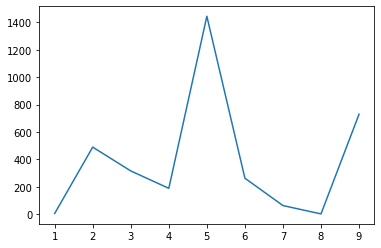

In [ ]:
possible_values = []
frequency = {i: 0 for i in range(1, 10)}

for k,v in mapper.items():
  for cat in v:
    if cat not in possible_values:
      frequency[cat] += 1
  
possible_values.sort()
print(frequency)
plt.plot(list(frequency.keys()), list(frequency.values()))

In [ ]:
df_images.shape[0]

1962

In [ ]:
image_size = 256
X_train, y_train = [], []

for index, row in df_images.iterrows():
    im = Image.open(train_dir + row["file_name"])
    im_array = convert_image_to_array(im, image_size=image_size)
    cat = np.zeros(9, dtype=int)
    for x in mapper[row["id"]]:
        cat[x - 1] = 1
    X_train.append(im_array)
    y_train.append(cat)
    


X_train = np.array(X_train)
y_train = np.array(y_train)

# YES, but this works slow :(

In [ ]:
X_train, y_train

(array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],
 
 
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0

In [ ]:
X_train.shape, y_train.shape, len(images_train_filenames)

((1962, 256, 256, 3), (1962, 9), 1962)

In [ ]:
X_test = []
id_test = []

for filename in images_test_filenames:
    im = Image.open(test_dir + filename)
    im_array = convert_image_to_array(im, image_size)
    X_test.append(im_array)
    id_test.append(filename)

[0 1 1 0 1 1 0 0 1]
0019_A_H_15_B.jpg
0017_E_H_15_A.jpg
1962
1962
1962


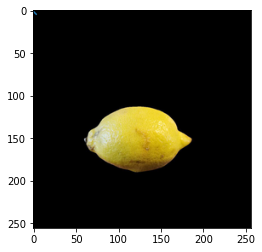

In [ ]:
max = 0
max_index = 0
for index, i in enumerate(y_train):
  summa = np.sum(i)
  if summa > max:
    max = summa
    max_index = index

plt.plot([1, 2, 3, 4])
plt.imshow(X_train[max_index] / 255)
print(y_train[max_index])
print(images_train_filenames[max_index])  # For some reason this thing tricks me!!!
print(df_images["file_name"][max_index])
print(len(X_train))
print(len(y_train))
print(len(images_train_filenames))

In [ ]:
def get_model():
    model = keras.models.Sequential()

    model.add(
        Conv2D(32, (3, 3), padding="same", input_shape=[image_size, image_size, 3])
    )
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(128, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.25))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(9))
    model.add(Activation("sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            keras.metrics.AUC(name="roc_auc", curve="ROC"),
            keras.metrics.AUC(
                name="roc_auc_multi_label", curve="ROC", multi_label=True
            ),
        ],
    )

    return model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.3,
)

In [ ]:
model = get_model()

model.summary()

NameError: ignored

In [ ]:
BS = 64
EPOCHS = 8

history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=aug.flow(X_train, y_train, batch_size=BS, subset='validation'),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS,
    verbose=1,
)

In [ ]:
X_test = tf.stack(X_test)
y_preds = model.predict_proba(X_test)

In [ ]:
for i in range(len(y_preds)):
    y_preds[i] = np.array(y_preds[i] >= 0.5)

y_preds = np.array(y_preds, dtype=int)


y_preds = pd.DataFrame(
    data=np.concatenate((np.array(id_test).reshape(-1, 1), y_preds), axis=1),
    index=None,
    columns=["image_id"] + list(map(str, range(1, 10))),
)

In [ ]:
# y_preds.to_csv("submission.csv", index=None)
y_preds